# Chemical oceanography variables prediction using physical oceanography variables and machine learning models


## Objective

* Use HOT data to train a model in order to predict chemical variables (oxgen, nitrient) based on physical variables (temperature, salinity, and pressure) due to the fact that physical variables are ususally easy to get

## Method
* Data cleaning to get ride of bad values.
* Data scaling to make sure the input data is at similar scale.
* Input - salinity, temperature, and pressure; output:N.
* Choose 70% data for training and 30% for testing.
* Follow the [sklearn instructions](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), tried three regression models (linear regression, Ridge regreesion, and Support Vector Regression) first with default model settings.
* Choose mean square error as model performance metrics.
* Choose the best model for fine-turning using [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) method.

## Results


In [5]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
%matplotlib inline  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")


# Read data from HOT
file_list = glob.glob('/home/jovyan/Ocean_ML/HOT/hot_rosette/*.csv')
fields = ['STNNBR', 'DATE', 'TIME', 'LATITUDE', 'LONGITUDE', 'CTDPRS', 'CTDTMP', 'CTDSAL', 'CTDOXY', 'CTDSAL_FLAG_W',
         'OXYGEN', 'OXYGEN_FLAG_W', 'SILCAT', 'SILCAT_FLAG_W', 'PHSPHT', 'PHSPHT_FLAG_W', 'NO2+NO3', 'NO2+NO3_FLAG_W']

df = pd.DataFrame(columns=fields)
df0 = pd.DataFrame(columns=fields)

for x in file_list:
    fil_name = x
    a = pd.read_csv(fil_name, skiprows=[0], comment='#')
    a = a[fields]
    a = a[a.STNNBR==2]
    a = a[a.CTDSAL_FLAG_W==2]
    df0=df0.append(a, ignore_index=True)
    a = a[a['NO2+NO3_FLAG_W']==2]
    #print(a.shape)
    df=df.append(a, ignore_index=True)
print('Before data cleaning:')
print(df0.shape)
print('After data cleaning:')
print(df.shape)

Before data cleaning:
(67021, 18)
After data cleaning:
(13867, 18)


In [9]:
#df.to_csv('HOT_N.csv')

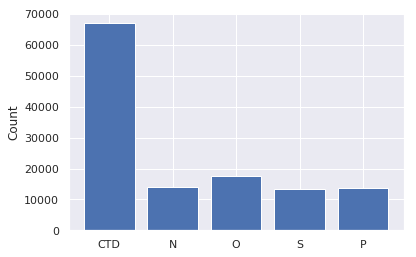

In [25]:
ctd_count = sum(df0.CTDSAL_FLAG_W==2)
n_count = sum(df0['NO2+NO3_FLAG_W']==2)
o_count = sum(df0['OXYGEN_FLAG_W']==2)
s_count = sum(df0['SILCAT_FLAG_W']==2)
p_count = sum(df0['PHSPHT_FLAG_W']==2)

plt.bar(['CTD', 'N', 'O', 'S', 'P'], [ctd_count, n_count, o_count, s_count, p_count], align='center')
plt.ylabel('Count')
plt.savefig('HOT_count.png')

Focus on N only for this case.

In [26]:
# Quality control for nutrients vales (should not be < 0)
# nutrient_fields = ['CTDOXY', 'OXYGEN', 'SILCAT', 'PHSPHT', 'NO2+NO3']
nutrient_fields = ['CTDPRS', 'CTDTMP', 'CTDSAL','NO2+NO3']
for x in nutrient_fields:
    print(x)
    print(df[x].astype(float).describe())

CTDPRS
count    13867.000000
mean      1210.216932
std       1391.782647
min          1.200000
25%        197.800000
50%        604.300000
75%       1800.500000
max       4813.800000
Name: CTDPRS, dtype: float64
CTDTMP
count    13867.000000
mean         9.986677
std          8.554803
min          1.440000
25%          2.378300
50%          5.808200
75%         18.997000
max         27.358000
Name: CTDTMP, dtype: float64
CTDSAL
count    13867.000000
mean        34.628203
std          0.368503
min         34.009100
25%         34.342000
50%         34.642400
75%         34.888200
max         35.546300
Name: CTDSAL, dtype: float64
NO2+NO3
count    13867.000000
mean        23.975217
std         17.196308
min         -0.030000
25%          2.245000
50%         35.380000
75%         39.390000
max         42.840000
Name: NO2+NO3, dtype: float64


In [27]:
df['NO2+NO3'][df['NO2+NO3'].astype(float)<0] = 0

## Exploratory data analysis

In [ ]:
# Exploratory data analysis
explot_df = df[['CTDPRS', 'CTDTMP', 'CTDSAL', 'NO2+NO3']].astype(float)
sns.pairplot(explot_df)

Follow the [sklearn instruction](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

In [12]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

input_var = ['CTDPRS', 'CTDTMP', 'CTDSAL']
output_var = ['NO2+NO3']
X_input = df[input_var]
y_output = df[output_var]

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_input, y_output, test_size=0.3, random_state=2018)

# Stardarlized the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Run several models with default settings and see which one is the best.
dict_model = {
    'Linear Regression': LinearRegression(),
    "Ridge Regression": Ridge(),
    "Linear SVR": SVR(),
}

dict_score={}
for model_name, model in dict_model.items():
    model.fit(X_train, y_train)
    # Test the model
    y_true, y_pred = y_test, model.predict(X_test)
    dict_score[model_name] = mean_squared_error(y_true, y_pred)
dict_score

{'Linear Regression': 18.08470749850166,
 'Linear SVR': 0.4749068861907489,
 'Ridge Regression': 18.085810228018243}

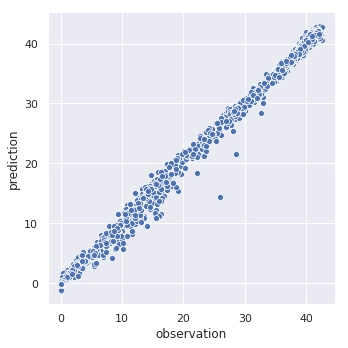

In [18]:
# plot observation vs prediction
dict_result = {'observation': y_true.values.astype(float).flatten(), 'prediction': np.array(y_pred)}
df_result = pd.DataFrame(dict_result)
splot = sns.relplot(x="observation", y="prediction", data=df_result);
splot.savefig('HOT_N_SVR_1.png')

In [15]:
svr = SVR()
    
pipe = Pipeline(steps=[('svr', svr)])
Cs = np.arange(0.01, 3, 0.2)
kernels = [ 'poly', 'rbf', 'sigmoid']

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(svr__C=Cs, svr__kernel=kernels))
estimator.fit(X_train, y_train)
y_true, y_pred = y_test, estimator.predict(X_test)
print(mean_squared_error(y_true, y_pred))

0.4411422420958231


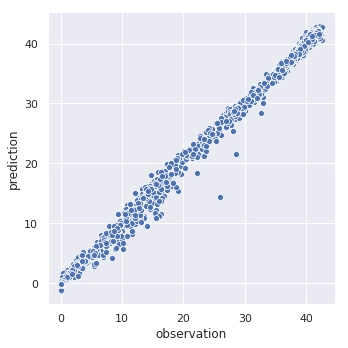

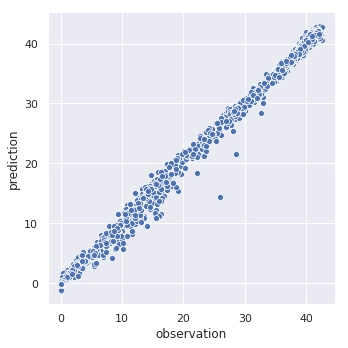

In [19]:
# plot observation vs prediction
dict_result = {'observation': y_true.values.astype(float).flatten(), 'prediction': np.array(y_pred)}
df_result = pd.DataFrame(dict_result)
splot = sns.relplot(x="observation", y="prediction", data=df_result);
splot.savefig('HOT_N_SVR_CV.png')

In [ ]:
# Save model
from sklearn.externals import joblib
joblib.dump(estimator, 'model_N.pkl') 

# load model
estimator = joblib.load('model_N.pkl') 